Please refer to my [Medium article](https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114) for code explanations!!

# Load the required libraries

In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# U-Net architecture

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [5]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [6]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [8]:
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 512, 512])


# Load the Carvana Dataset

In [9]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        
        return min(len(self.images), self.limit)

In [2]:

print(os.listdir("../input/carvana-image-masking-challenge/"))

DATASET_DIR = '../input/carvana-image-masking-challenge/'
WORKING_DIR = '/kaggle/working/'

['train_masks.zip', '29bb3ece3180_11.jpg', 'train_masks.csv.zip', 'train.zip', 'metadata.csv.zip', 'sample_submission.csv.zip', 'test.zip', 'test_hq.zip', 'train_hq.zip']


In [3]:
if len(os.listdir(WORKING_DIR)) <= 1:

    with zipfile.ZipFile(DATASET_DIR + 'train.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    with zipfile.ZipFile(DATASET_DIR + 'train_masks.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)
    
    print(
        len(os.listdir(WORKING_DIR + 'train')),
        len(os.listdir(WORKING_DIR + 'train_masks'))
    )

5088 5088


In [10]:
train_dataset = CarvanaDataset(WORKING_DIR)

generator = torch.Generator().manual_seed(25)


In [12]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

In [13]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

if device = "cuda":
    num_workers = torch.cuda.device_count() * 4

'cuda'

In [18]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

In [21]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Running the experiment

In [22]:

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [23]:
torch.cuda.empty_cache()

In [24]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), 'my_checkpoint.pth')


 10%|█         | 1/10 [06:54<1:02:09, 414.40s/it]

------------------------------
Training Loss EPOCH 1: 0.1945
Training DICE EPOCH 1: 0.7723


Validation Loss EPOCH 1: 0.0413
Validation DICE EPOCH 1: 0.9606
------------------------------


 20%|██        | 2/10 [13:47<55:09, 413.72s/it]  

------------------------------
Training Loss EPOCH 2: 0.0304
Training DICE EPOCH 2: 0.9714


Validation Loss EPOCH 2: 0.0201
Validation DICE EPOCH 2: 0.9812
------------------------------


 30%|███       | 3/10 [20:40<48:14, 413.51s/it]

------------------------------
Training Loss EPOCH 3: 0.0535
Training DICE EPOCH 3: 0.9464


Validation Loss EPOCH 3: 0.0658
Validation DICE EPOCH 3: 0.9384
------------------------------


 40%|████      | 4/10 [27:34<41:20, 413.42s/it]

------------------------------
Training Loss EPOCH 4: 0.0255
Training DICE EPOCH 4: 0.9763


Validation Loss EPOCH 4: 0.0155
Validation DICE EPOCH 4: 0.9856
------------------------------


 50%|█████     | 5/10 [34:27<34:26, 413.40s/it]

------------------------------
Training Loss EPOCH 5: 0.0140
Training DICE EPOCH 5: 0.9870


Validation Loss EPOCH 5: 0.0122
Validation DICE EPOCH 5: 0.9886
------------------------------


 60%|██████    | 6/10 [41:20<27:33, 413.41s/it]

------------------------------
Training Loss EPOCH 6: 0.0113
Training DICE EPOCH 6: 0.9894


Validation Loss EPOCH 6: 0.0110
Validation DICE EPOCH 6: 0.9896
------------------------------


 70%|███████   | 7/10 [48:14<20:40, 413.40s/it]

------------------------------
Training Loss EPOCH 7: 0.0097
Training DICE EPOCH 7: 0.9909


Validation Loss EPOCH 7: 0.0090
Validation DICE EPOCH 7: 0.9914
------------------------------


 80%|████████  | 8/10 [55:07<13:46, 413.40s/it]

------------------------------
Training Loss EPOCH 8: 0.0087
Training DICE EPOCH 8: 0.9917


Validation Loss EPOCH 8: 0.0087
Validation DICE EPOCH 8: 0.9916
------------------------------


 90%|█████████ | 9/10 [1:02:01<06:53, 413.51s/it]

------------------------------
Training Loss EPOCH 9: 0.0080
Training DICE EPOCH 9: 0.9923


Validation Loss EPOCH 9: 0.0075
Validation DICE EPOCH 9: 0.9928
------------------------------


100%|██████████| 10/10 [1:08:55<00:00, 413.52s/it]


------------------------------
Training Loss EPOCH 10: 0.0083
Training DICE EPOCH 10: 0.9921


Validation Loss EPOCH 10: 0.0074
Validation DICE EPOCH 10: 0.9928
------------------------------


# Results

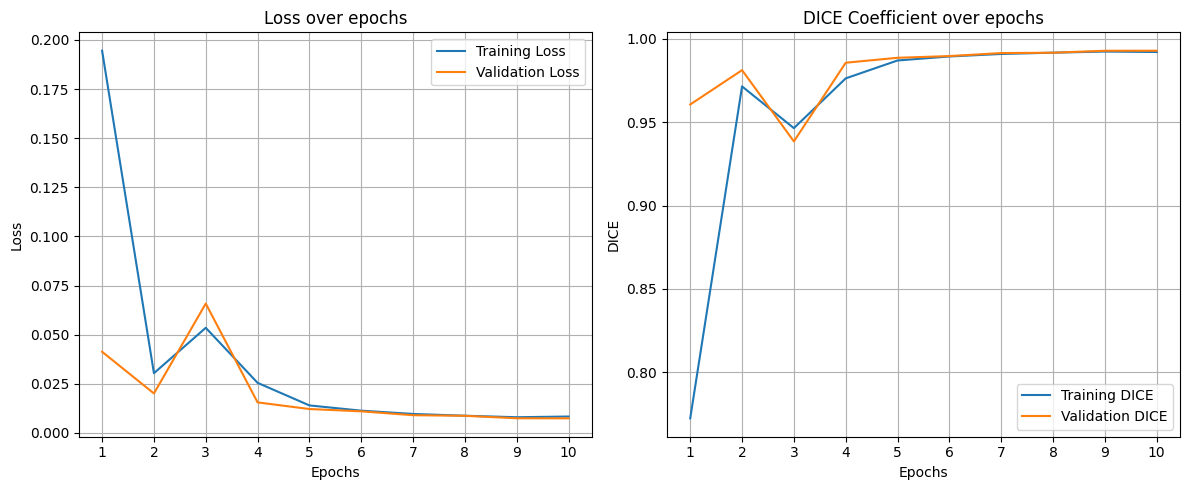

In [38]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


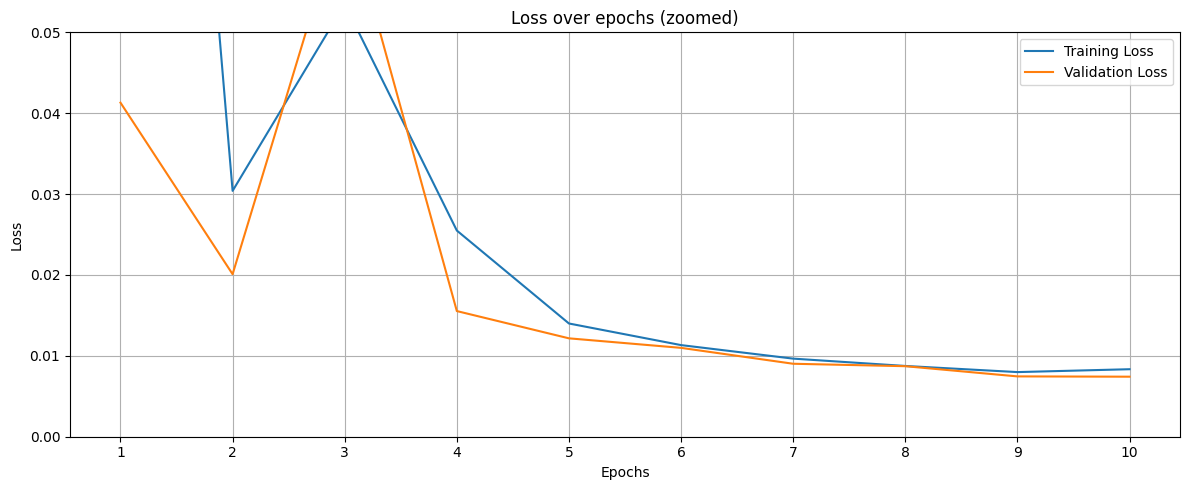

In [26]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()



In [27]:
model_pth = '/kaggle/working/my_checkpoint.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

<All keys matched successfully>

In [28]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)


100%|██████████| 64/64 [00:20<00:00,  3.18it/s]


In [39]:
test_loss

0.007724014394625556

In [40]:
test_dc

0.9926938228309155

In [36]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [41]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 



Image: a56f923399ca_02.jpg, DICE coefficient: 0.99303


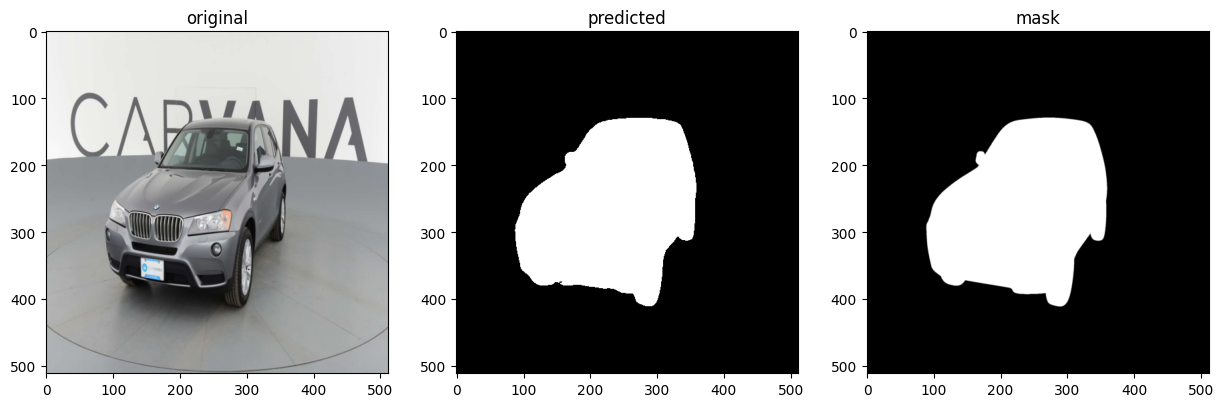

Image: dc1c5c2b9e49_13.jpg, DICE coefficient: 0.99444


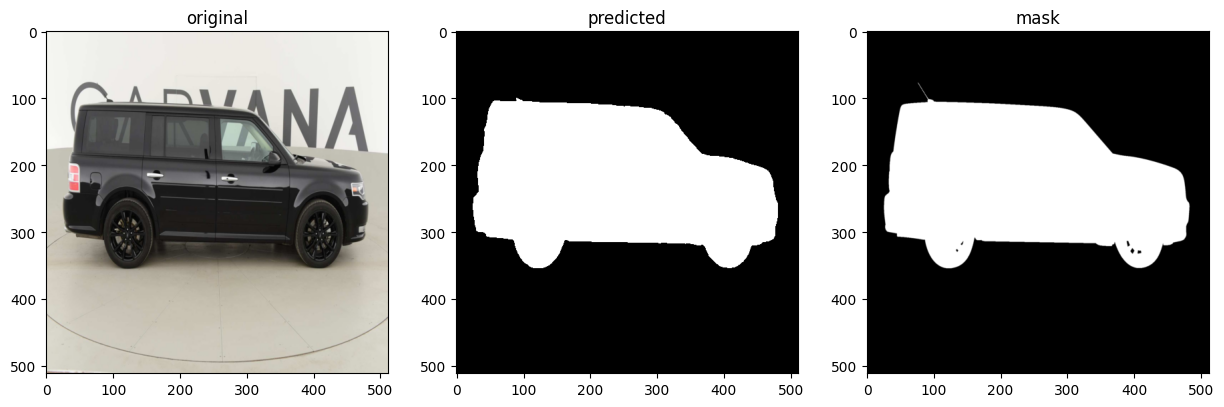

Image: 424658d9f222_06.jpg, DICE coefficient: 0.99485


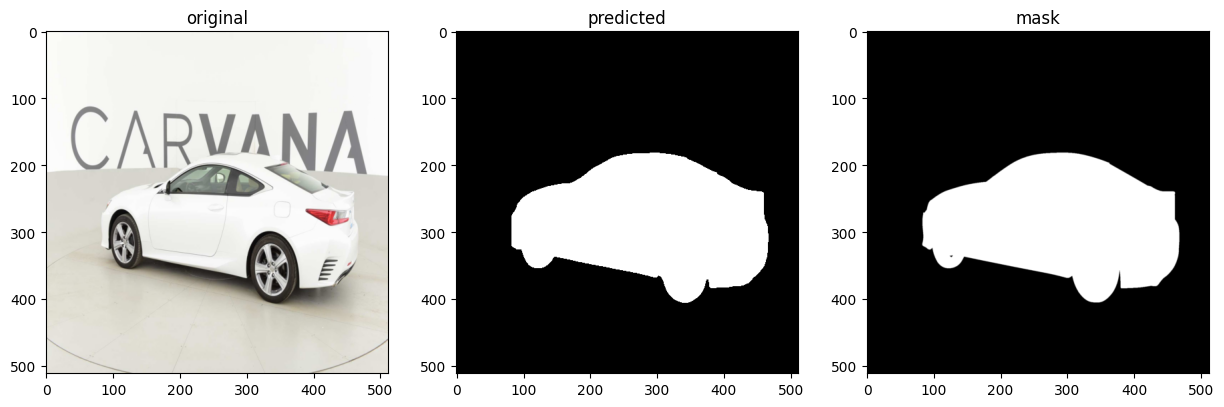

Image: 2990f858e939_08.jpg, DICE coefficient: 0.99485


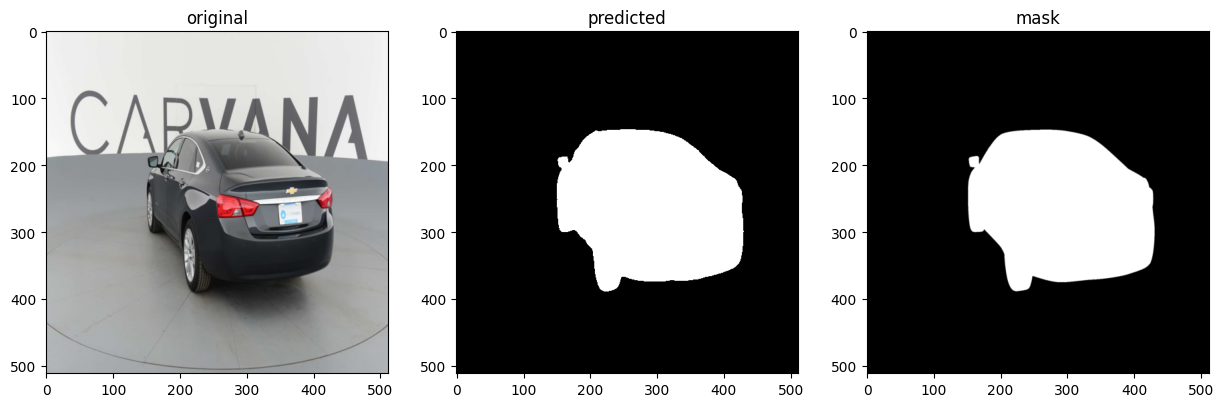

Image: 9cc257b449d0_16.jpg, DICE coefficient: 0.99445


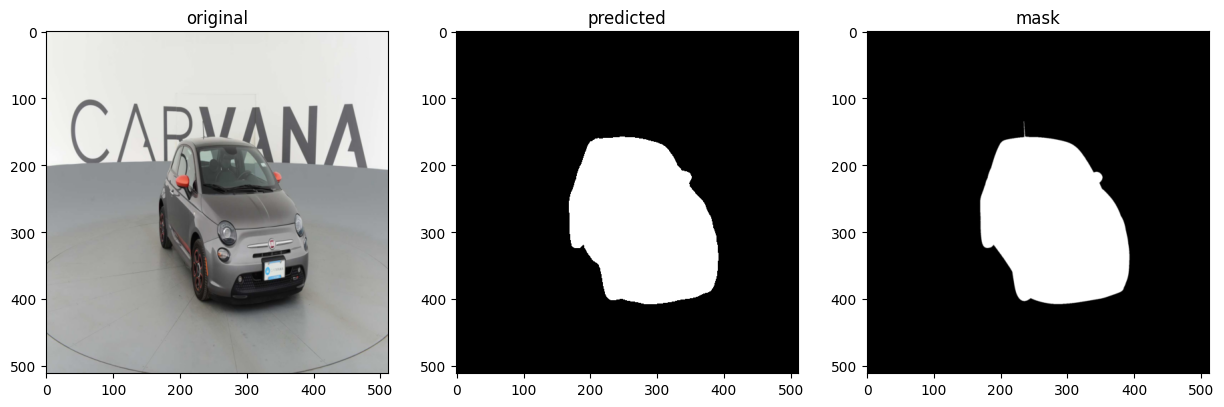

Image: 1b25ea8ba94d_07.jpg, DICE coefficient: 0.99513


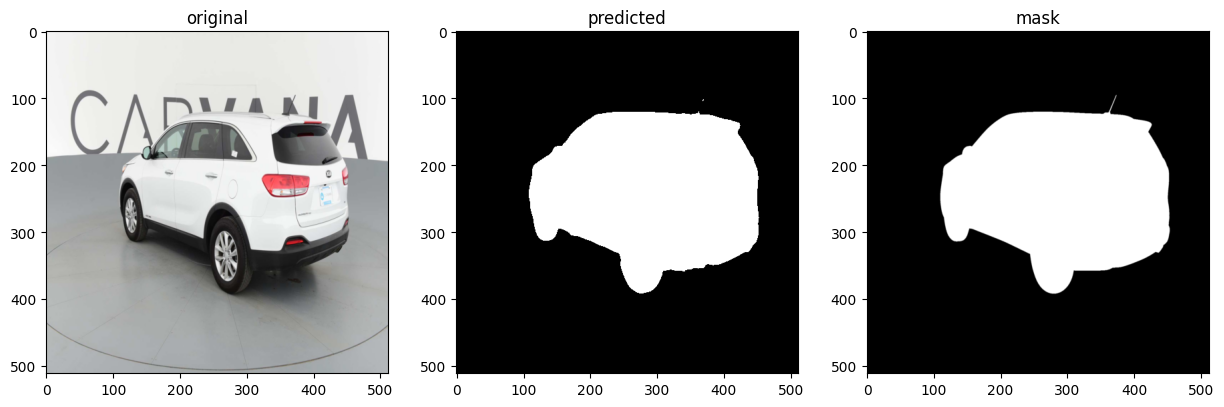

Image: 6bf969856536_08.jpg, DICE coefficient: 0.99524


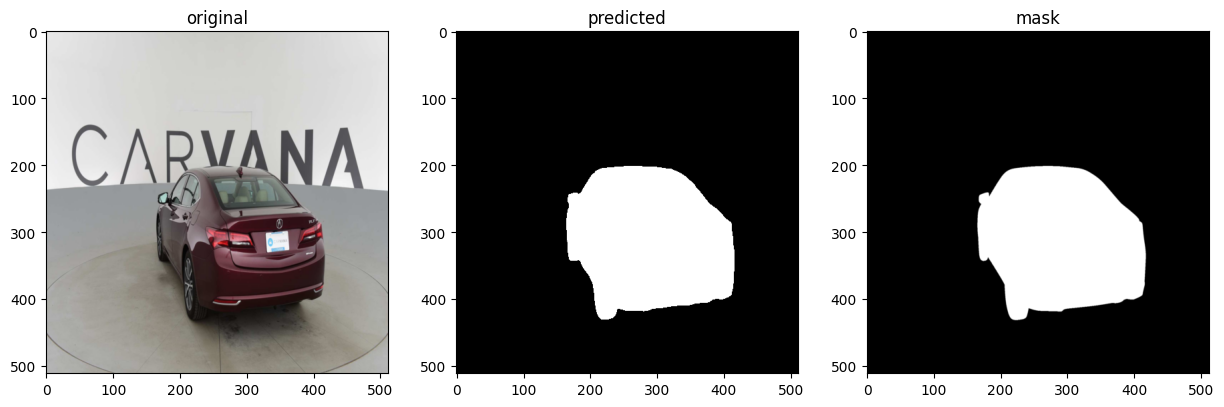

Image: ae296a20fdd9_02.jpg, DICE coefficient: 0.98612


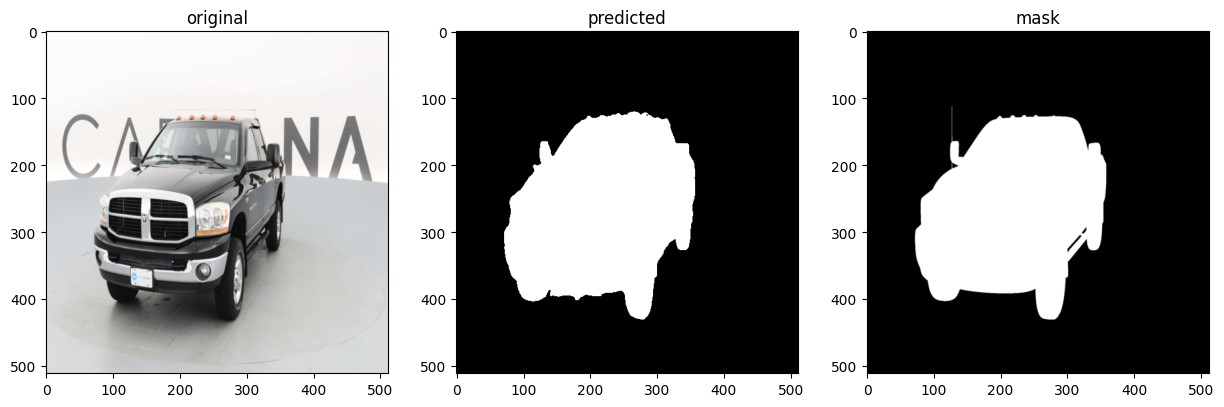

Image: 78f63d808555_01.jpg, DICE coefficient: 0.99412


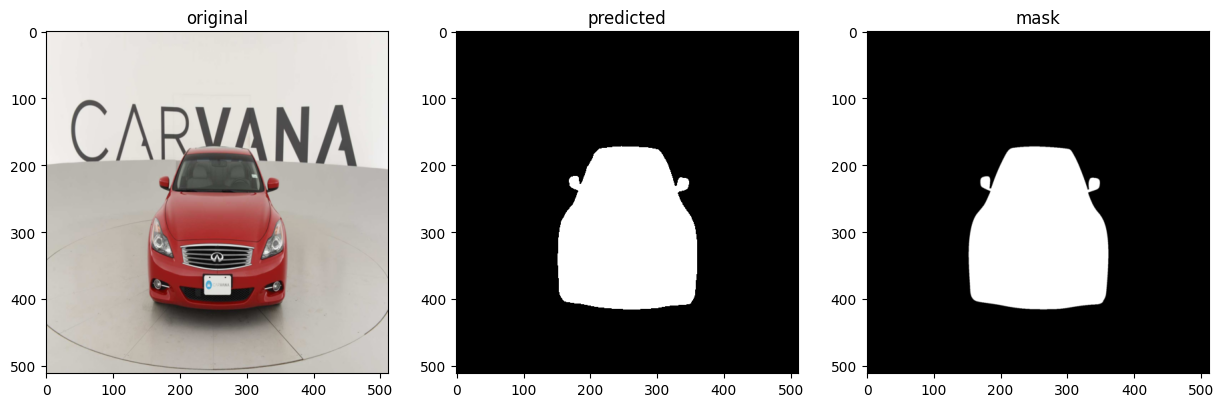

Image: 32ff007d9505_04.jpg, DICE coefficient: 0.99209


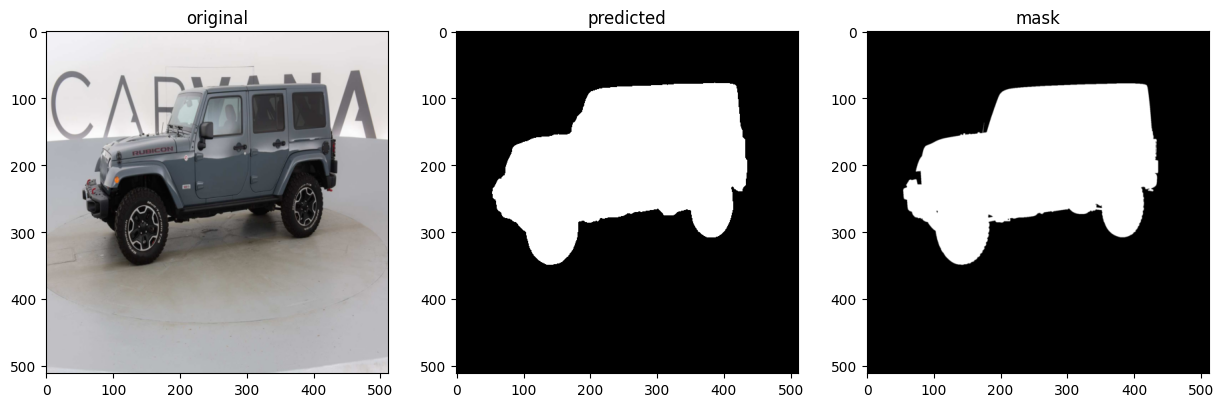

In [42]:
model_path = '/kaggle/working/my_checkpoint.pth'

random_images_inference(image_tensors, mask_tensors, image_paths, model_pàth, device="cpu")

# Optional: checking the masks in the training

Image: e8f607100c1f_15.jpg, DICE coefficient: 0.99464


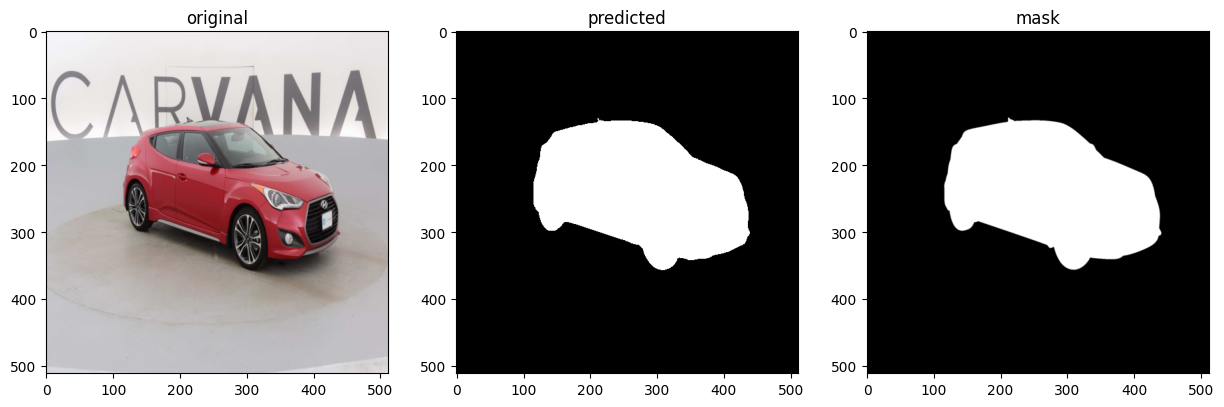

Image: 1258cf954183_01.jpg, DICE coefficient: 0.98963


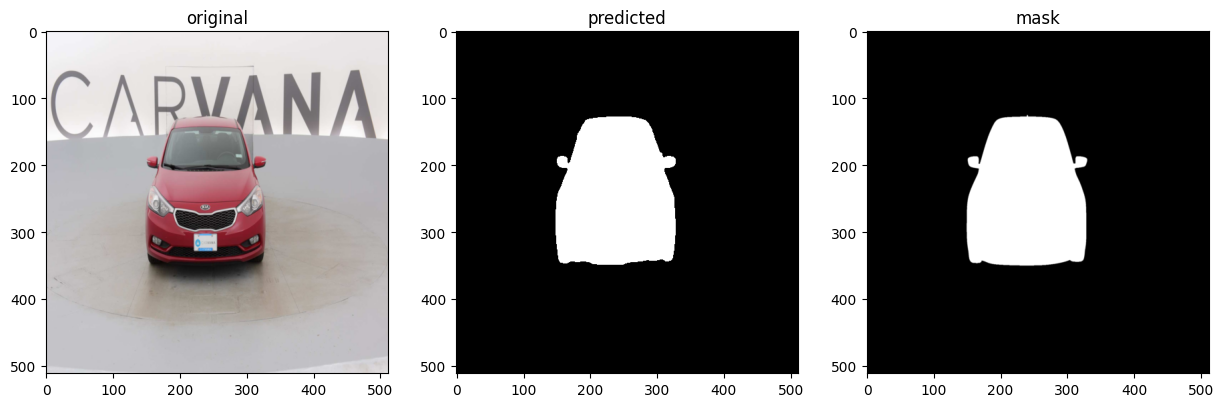

Image: 42b3feca1993_13.jpg, DICE coefficient: 0.99266


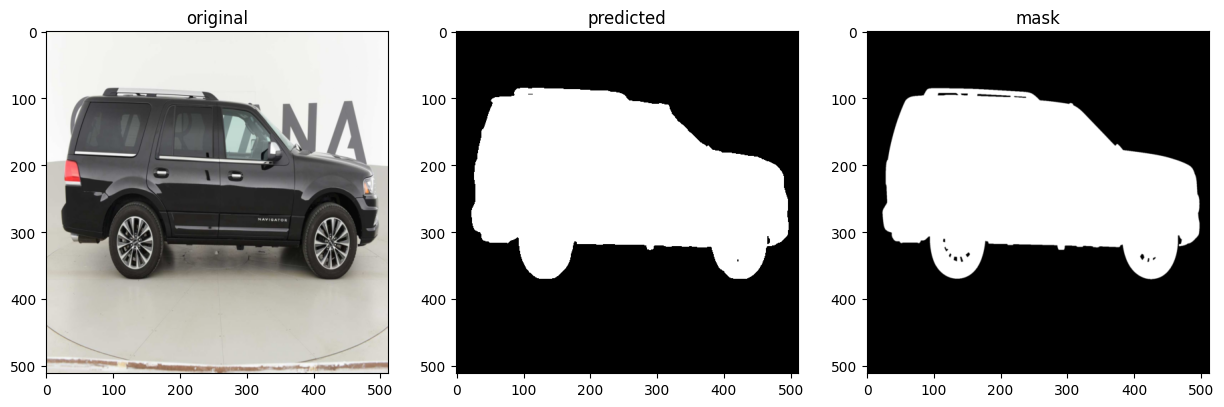

Image: 5df60cf7cab2_01.jpg, DICE coefficient: 0.99198


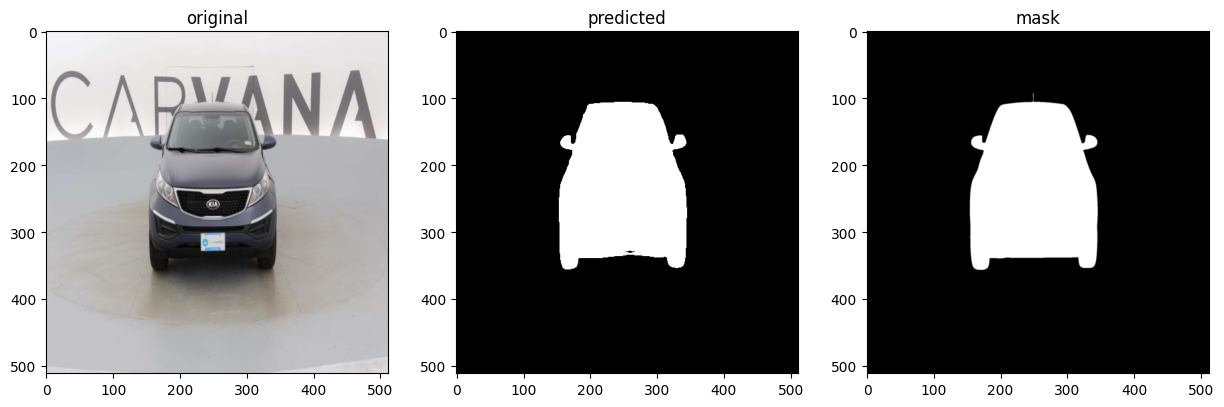

Image: 4e308ad8a254_02.jpg, DICE coefficient: 0.99413


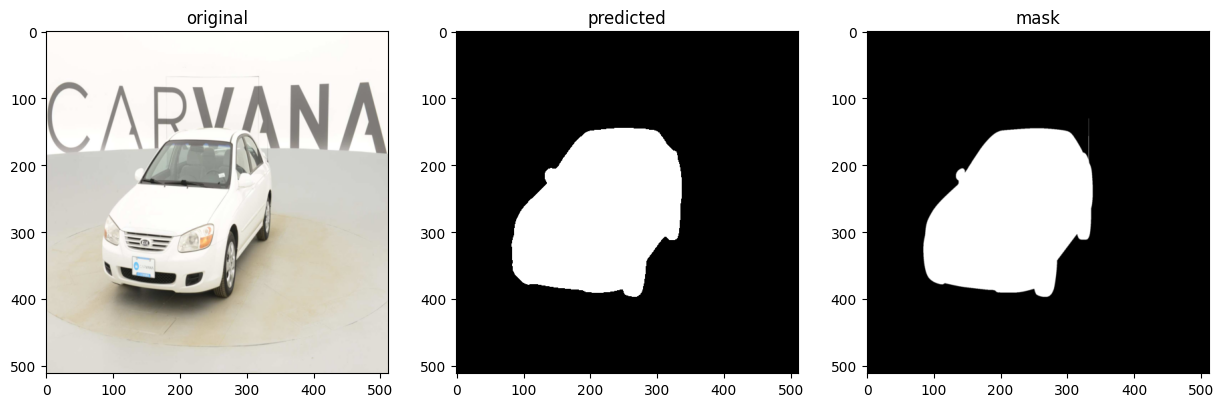

Image: e2230d0ceb02_07.jpg, DICE coefficient: 0.99481


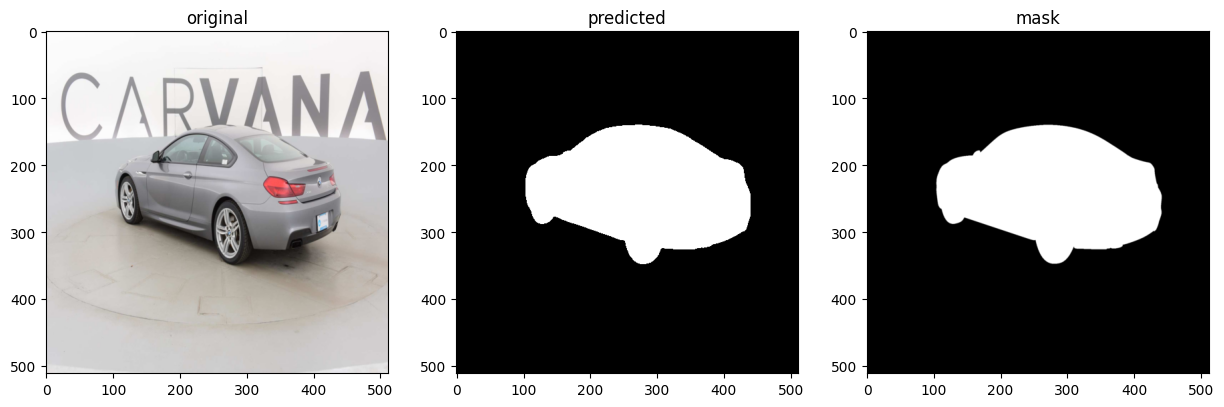

Image: f707d6fbc0cd_10.jpg, DICE coefficient: 0.99138


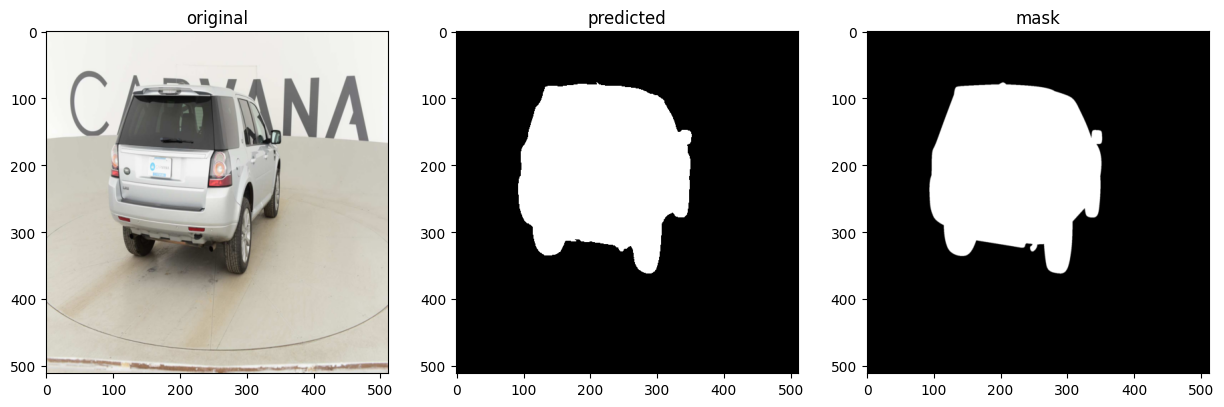

Image: 2ea62c1beee7_10.jpg, DICE coefficient: 0.99432


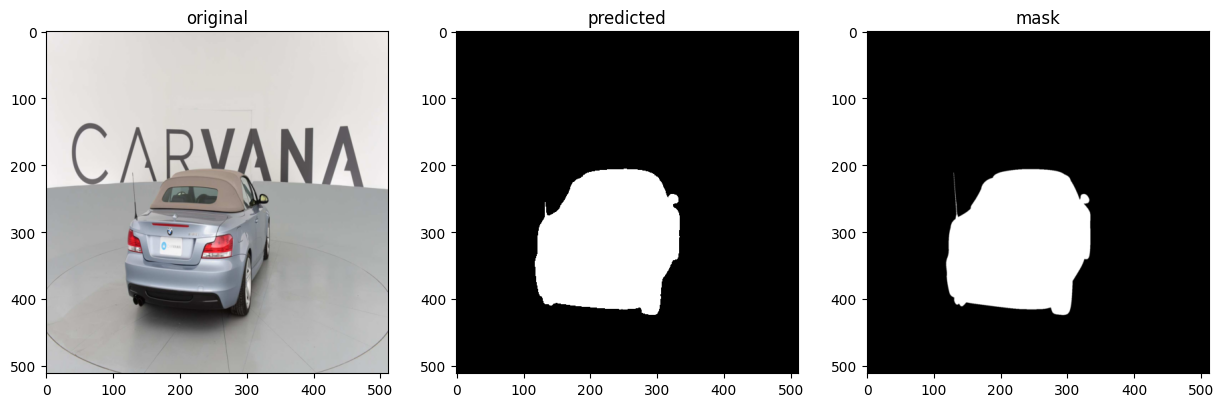

Image: d8e1c401ac3c_03.jpg, DICE coefficient: 0.99445


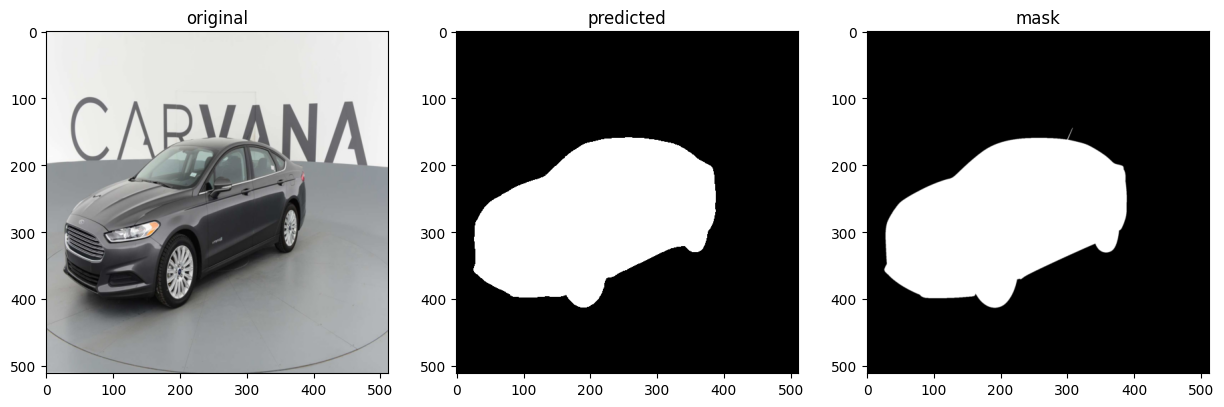

Image: 419687d50dcd_02.jpg, DICE coefficient: 0.99327


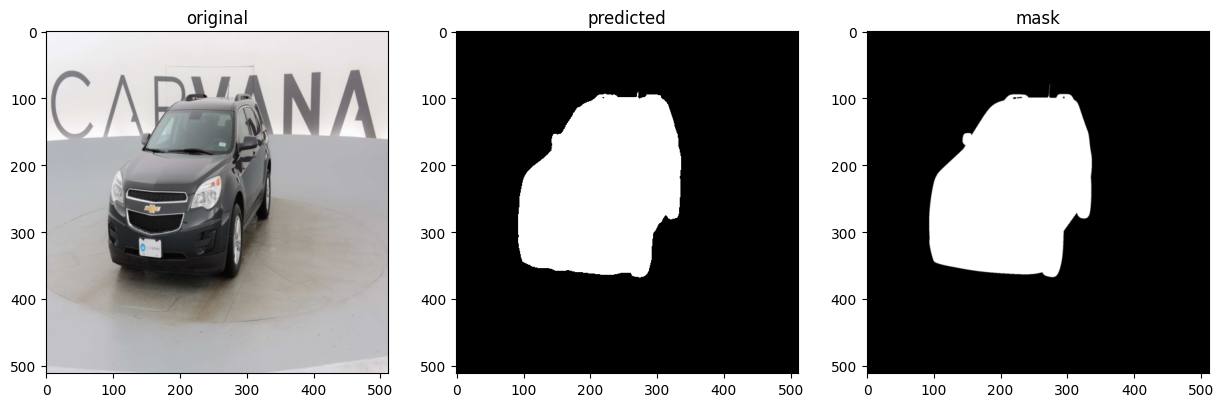

In [46]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_pàth, device="cpu")